In [3]:
##Health cost of grid for badarpur 
h_cost_badarpur  = 24*30*7.17E-4


In [4]:
def P_sol(HRES,t,Nps,F_loss,n_MPPT):
    from scipy.io import loadmat
    annots = loadmat('solar_new.mat')
    Ps_new = annots['Ps_new']
    
    import numpy as np
    import pandas as pd
    from scipy import interpolate
    x = np.linspace(1,24,24) 
    y = Ps_new.transpose()
    tck = interpolate.splrep(x,y)
    P_solar = interpolate.splev(t, tck) #W/m2
    
    return P_solar

In [5]:
def P_wind(HRES,t, N, h):
    
    from scipy.io import loadmat
    annots = loadmat('wind_new.mat')
    Pw_new = annots['Pw_new']
    
    import numpy as np
    import pandas as pd
    from scipy import interpolate
    x = np.linspace(1,24,24) 
    y = Pw_new.transpose()
    tck = interpolate.splrep(x,y)
    P_w = interpolate.splev(t, tck) #W/m2

    return P_w

In [6]:
from gekko import GEKKO
m = GEKKO(remote = False)


In [7]:
def Single_HRES(tim, HRES, Tr, T, g_buy, g_sell, P_dgr, Nps, Nw, Nh, eta_c, V_cl2_max, V_cl2_min, N_fc_s, n_fc_max_in, n_fc_in, w1, w2, w3, f1_o, f1_max, f2_o, f2_max, f3_o, f3_max, lb_ATR):
#   Single_HRES(HRES='1',tim=tim,Tr=Tr,T=T,Nh=100,Nps=4000,Nw=15,eta_c=1000,N_fc_s=30,P_dgr=200,V_cl2_max=10000,V_cl2_min=8000, n_fc_in=n_fc_i[0], n_fc_max_in =n_fc_max_i[0],g_buy=b_grid,g_sell=s_grid)

    import numpy as np
    import pandas as pd
    from scipy import interpolate
    #import matplotlib.pyplot as plt
    from gekko import GEKKO
    
    m = GEKKO(remote = False)
    C_buy = m.Const(g_buy)  #INR/kwh  buying from the grid
    C_sell = m.Const(g_sell) #INR/Kwh as per net metering  selling to the grid
    
    ### Diesel generator  
    #P_dgr = 10#maximum rated power of generator KW/hr
    A_dg = 0.246 #litre/Kwh
    B_dg = 0.08145 #litre/Kwh
    C_fuel = 30 #Rs/litre

    ###  Solar Panels ##
    #Nps = 300       #no. of cell in parallel  no. of cell in series
    F_loss = 0.95  #loss due to dust
    n_MPPT = 0.95 # MPPT device efficiency
    C_PV = 3.6 # INR/kwh
    P_sol_max = P_sol(HRES,tim,Nps,F_loss,n_MPPT) #kw/hr
    
    ###  Wind Power  ####
    #Nw = 8 #no. of wind turbines
    ht = 20 #height of the turbine (metres)
    C_wind = 3.0 #INR/kW
    P_wind_max = P_wind(HRES,tim,Nw, ht)  #kw/hr

    ###   Demand function  ####
    #Nh = 20 #no. of househiolds
    from scipy.io import loadmat
    annots = loadmat('load_new.mat')
    Pl_new = annots['Pl_new']
    import numpy as np
    import pandas as pd
    from scipy import interpolate
    x = np.linspace(1,24,24) 
    y = Pl_new.transpose()
    tck = interpolate.splrep(x,y)
    P_l = interpolate.splev(tim, tck) #W/m2
    
    
    ####   Electrolyzer(PHOEBUS)/cell   #######
    #eta_c = 120 #no. of cells in series power range (400 - 600W)
    eta_f = 0.95
    z = 2
    F = 98485 #Cmol-1
    a_el = 3600*eta_f/(z*F)
    Tc = 40 #C  35<= T <=90
    U_rev = 1.184 #V
    A = 0.25 #m^2 electrode area
    ######
    r1 = -3.0071e-004 #omega m^2
    r2 =  1.1211e-005 #omega m^2 C-1
    r = r1 + r2*Tc #omega m^2
    #####
    s1 = 0.2772353 #V
    s2 = -0.0024638 #VC-1
    s = s1 + s2*Tc #V
    t1 = -1.4421e+000 #A-1m^2
    t2 = 5.6183e-002 #A-1m2C
    t3 = -3.9527e-004 #A-1m2C2
    t = t1 + t2*Tc + t3*(Tc**2) #A-1m^2
    ##
    Vol_cl2_max = V_cl2_max/T #(litres) maximum oxygen can stored in a day at Temp = 25C and P=24bar
    Vol_cl2_min = V_cl2_min/T
    n_cl2_max = (24*Vol_cl2_max/(0.082*298))*np.ones(Tr)
    n_cl2_min = (24*Vol_cl2_min/(0.082*298))*np.ones(Tr)
    #C_elec = 4.0 #INR/kW
    #C_cl2 = 1.4 #INR/mol 20 INR/kg
    
    ####   Fuel cell Stack model ##########(200W - 400W)
    #N_fc_s = 4 # no. of fuel cell stacks
    eta_fc = 0.7
    N_cell = 35 #35 cell in series
    a_fc = 3600*eta_fc*N_cell/(z*F)
    U_fc0 = 33.18 #V
    e1 = -0.013 #VC-1
    e2 = -1.57 #V
    I_fc0 = 8.798 #A
    R_fc = -2.04 #ohmC-1
    T_fc = 25 #C
    C_h2 = 75*14 #INR/kg 14 dollars per kg
    C_h2 = C_h2/500; #INR/mol
    C_fc = 3.5 #INR/kW
    ####
         
    P_fc = [m.Var(lb = 0) for i in range(Tr)]
    
    P_grid1 = [m.Var() for i in range(Tr)]
    
    P_grid2 = [m.Var(lb = 0) for i in range(Tr)]

    P_cr1 = [m.Var(lb = 0) for i in range(Tr)]
        
    P_dg1 = [m.Var(lb = 0) for i in range(Tr)]
        
    P_dg2 = [m.Var(lb = 0) for i in range(Tr)]
        
    n_fc2 = [m.Var(lb = 0) for i in range(Tr)]
    
    P_cr2 = [m.Var(0, lb = 0) for i in range(Tr)]
    n_h2 = [m.Var(0, lb = 0) for i in range(Tr)]
    n_fc = [m.Var(0, lb = 0) for i in range(Tr)]
    n_fc_max = [m.Var(0, lb = 0) for i in range(Tr)]
    
    FSCR = [m.Var(0, lb = 0) for i in range(Tr)]
    ZSCR = [m.Var(0, lb = 0) for i in range(Tr)]
    X_SCR = [m.Var(0, lb = 0, ub = 1) for i in range(Tr)]
    
    ATR = [m.Var(0, lb = lb_ATR) for i in range(Tr)]
    
        
    P_dg = [None]*Tr
    P_grid = [None]*Tr
    P_fcin = [None]*Tr
    for i in range(Tr):
        P_dg[i] = m.Intermediate(P_dg1[i] + P_dg2[i])
        P_grid[i] = m.Intermediate(P_grid1[i] + P_grid2[i])
        P_fcin[i] = m.Intermediate(P_grid2[i] + P_dg2[i] + P_cr2[i])
    

    m.Equations([P_cr2[i] == - P_cr1[i] + P_sol_max[i] + P_wind_max[i] for i in range(Tr)]) 
    m.Equations([1000*(P_cr2[i]+P_dg2[i]+P_grid2[i])/eta_c ==(n_h2[i]/a_el)*U_rev+ (r/A)*((n_h2[i]/a_el)**2) +(n_h2[i]/a_el)*s*m.log((t/A)*(n_h2[i]/a_el) + 1) for i in range(Tr)])
    m.Equations([P_l[i] == P_fc[i] + P_cr1[i] + P_dg1[i] + P_grid1[i] for i in range(Tr)])
    
#     Pg_max = 100
#     m.Equations([Pg_max >= P_grid1[i] + P_grid2[i] for i in range(Tr)])
        
    m.Equations([P_dgr >= P_dg1[i] + P_dg2[i] for i in range(Tr)])
    m.Equation(n_fc_max[0] == n_fc_max_in + eta_c*n_h2[0] -N_fc_s*n_fc_in)
    m.Equations([n_fc_max[i] == n_fc_max[i-1] +eta_c*n_h2[i] - N_fc_s*n_fc[i-1] for i in range(1,Tr)])
    m.Equations([1000*P_fc[i]/N_fc_s == ((n_fc[i]+n_fc2[i])/a_fc)*U_fc0 + ((n_fc[i]+n_fc2[i])/a_fc)*e1*T_fc + ((n_fc[i]+n_fc2[i])/a_fc)*e2*m.log( ((n_fc[i]+n_fc2[i])/a_fc)*(1/I_fc0) + 1) + (R_fc/T_fc)*(((n_fc[i]+n_fc2[i])/a_fc)**2) for i in range(Tr)])
    m.Equations([n_fc[i]*N_fc_s <= n_fc_max[i] for i in range(Tr)])
    m.Equations([n_h2[i]*eta_c <= n_cl2_max[i]   for i in range(Tr)])
    m.Equations([n_h2[i]*eta_c >= n_cl2_min[i] for i in range(Tr)])
    
    EF =38.24                ###### 0.5
    m.Equations([FSCR[i] ==( A_dg*P_dg[i]*EF+ 2.23*P_grid[i])/1000  for i in range(Tr)])
    m.Equations([ZSCR[i] >= FSCR[i]  for i in range(Tr)])

    from scipy.io import loadmat
    annots = loadmat('DF15_new2.mat')
    Jd_data = annots['DF15']
    jd =2* Jd_data[int(tim-1)]
    global sum_jd
    sum_jd = (0.16+(0.32-0.16)*(np.sum(tim)/24))*24*0.3*30*sum(jd)
# #     print(DF15)

    
    
    m.Equations([ ATR[i]*sum_jd >= FSCR[i] - 1*FSCR[i]*X_SCR[i]   for i in range(Tr)])
#     print([ ATR[i]*sum_jd >= FSCR[i] -1*FSCR[i]*X_SCR[i]   for i in range(Tr)])
    C_grid = [None]*Tr
    for i in range(Tr):
        C_grid[i] = m.if2(P_grid1[i]+P_grid2[i],C_sell,C_buy) #Rs/Kwh
     
    cost = [None]*Tr
    for i in range(Tr):
        cost[i] = m.Intermediate((C_fuel*(A_dg*P_dg[i]) + C_PV*P_sol_max[i] +C_wind*P_wind_max[i]+ C_fc*P_fc[i])/(P_sol_max[i] + P_wind_max[i] + P_fc[i] + P_dg[i]) )
    cost_grid1 = np.multiply(C_grid,P_grid1)
    cost_grid2 = np.multiply(C_grid,P_grid2)
    
    c_atr = 37 #159.274
    ofu = 75
    cost_SCR = 100
    f1 = cost_SCR*np.sum(ZSCR)+np.sum(cost_grid1)+np.sum(cost_grid2)+C_fuel*A_dg*np.sum(P_dg1)+C_fuel*A_dg*np.sum(P_dg2)+C_h2*N_fc_s*np.sum(n_fc2) + c_atr*np.sum(ATR) + ofu* 1*np.sum(FSCR)*np.sum(X_SCR)
    f2 = h_cost_badarpur*(np.sum(P_grid1)+np.sum(P_grid2)) 
    f3 = ((100 - np.sum(P_dg1) - np.sum(P_dg2))/100)**2+ ((50-np.sum(P_sol_max))/50)**2 + ((450-np.sum(P_wind_max))/450)**2 + ((26 - np.sum(P_fc))/26)**2
    m.Obj(w1*(f1-f1_o)/(f1_max-f1_o) + w2*(f2-f2_o)/(f2_max-f2_o) + w3*(f3-f3_o)/(f3_max-f3_o) )  
#     m.Obj(w1*(f1) + w2*(f2) + w3*(f3))
    
#     print(pqr)
    m.options.IMODE = 3 #control
    m.options.SOLVER = 3#possible values 1,2,3 #3. IPOPT - int3rior point, #1. APOPT
    m.options.MAX_ITER = 1000
    m.options.OTOL = 0.001#tolerance
#     m.options.COLDSTART=2
#     m.options.TIME_SHIFT=0
#     m.options.COLDSTART=0
#     m.solve()
    m.solve(disp = False)
    del m
    
    SCO = np.round(ATR[0].value[0]*sum_jd,3) 
    DCO = np.round(FSCR[0].value[0]- 1*FSCR[0].value[0]*X_SCR[0].value[0],3)
    ah = SCO >= DCO
    print(ah)
    if ah==0:
        aht
    
    return P_grid,P_grid1,P_grid2,P_cr1,P_cr2, P_fc, P_dg1, P_dg2, P_dg, n_h2, n_fc, n_fc2, n_fc_max, P_l, P_sol_max, P_wind_max, P_fcin, C_grid, cost, ATR, X_SCR, FSCR, SCO, DCO, ZSCR


In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

f1_list = pd.read_csv('f1_list.csv')
F1 = np.array(f1_list)[:,1:4]

f2_list = pd.read_csv('f2_list.csv')
F2 = np.array(f2_list)[:,1:4]

f3_list = pd.read_csv('f3_list.csv')
F3 = np.array(f3_list)[:,1:4]


from scipy.io import loadmat
annots = loadmat('weights.mat')
# W = annots['w_list']
W = [[1,0,0],[0,1,0],[0,0,1]]

###########################################################
number_of_weightsets = 30
import random
random.seed(10)                                                                                      #10
W = []
for i in range(number_of_weightsets):
    m = random.uniform(0,1)
    n = random.uniform(0,1-m)
    W.append([m, n, 1-m-n])
# print(W)
##########################################################
# print(W)
Ts = 1
T = 24 ## Total time period(in 15 days)
Tr = 1
Ng = 1 #total no. of grid

n_fc_i = np.zeros(Ng)
n_fc_max_i = np.zeros(Ng)

P_cr2T = np.zeros([T,len(W)])
P_fcT = np.zeros([T,len(W)])
P_cr1T = np.zeros([T,len(W)])
P_dg1T = np.zeros([T,len(W)])
P_dg2T = np.zeros([T,len(W)])
P_dgT = np.zeros([T,len(W)])
n_h2T = np.zeros([T,len(W)])
n_fcT = np.zeros([T,len(W)])
n_fc2T = np.zeros([T,len(W)])
n_fc_maxT  =np.zeros([T,len(W)])
P_gridT = np.zeros([T,len(W)])
P_grid1T = np.zeros([T,len(W)])
P_grid2T = np.zeros([T,len(W)])
C_gridT = np.zeros([T,len(W)])
P_lT    =  np.zeros([T,len(W)])
P_sol_maxT =  np.zeros([T,len(W)])
P_wind_maxT = np.zeros([T,len(W)])
P_fcinT = np.zeros([T,len(W)])
costT = np.zeros([T,len(W)])

ATRT = np.zeros([T,len(W)])
X_SCRT = np.zeros([T,len(W)])
FSCRT = np.zeros([T,len(W)])
ZSCRT = np.zeros([T,len(W)])
SCOT = np.zeros([T,len(W)])
DCOT = np.zeros([T,len(W)])

P_mgs = np.zeros(Ng)

P_buy = np.zeros([T,len(W)])
P_sell = np.zeros([T,len(W)])
P_ds = np.zeros([T,Ng,Ng])
P_ds_buy = np.zeros([T,Ng,Ng])
P_ds_sell = np.zeros([T,Ng,Ng])
P_ms = np.zeros([T,Ng])
P_ms_buy = np.zeros([T,Ng])
P_ms_sell = np.zeros([T,Ng])

P_loss = np.zeros(T)
P_loss_un = np.zeros(T)
Total_c = np.zeros(T)
Total_c_un = np.zeros(T)
TMV = np.zeros(T)
TMV_un = np.zeros(T)

P_loss[:] = np.nan
Total_c[:] = np.nan
TMV[:] = np.nan


b_grid = 7.5+ 24*30*7.17E-4              # INR buying from the grid
s_grid = 3.75               # INR selling to the grid

o_charg = 0.25 #INR/Kwh overhead charges
ask = np.array([3.56, 3.42, 3.69, 3.06, 3.29]) + o_charg*np.ones(Ng)
spread = 1.5
bid = ask + spread*np.ones(Ng)

lb_ATR = 3.97 # 22.996/1.35 ######14.715/1.2
for h in range(0,T):
    print(h)
    tim= np.linspace(h,Tr+h-1,Tr)
      
    f1_o = F1[h][1-1]
    f1_max = max(F1[h])

    f2_o = F2[h][2-1]
    f2_max = max(F2[h])

    f3_o = F3[h][3-1]

    f3_max = max(F3[h])
        
    for i in range(0,len(W)):
        w1 = W[i][0]
        w2 = W[i][1]
        w3 = W[i][2]
        print('w1=',w1,'w2=',w2, 'w3=',w3)
        
#         f1_o = F1[h][1-1]
#         f1_max = max(F1[h])

#         f2_o = F2[h][2-1]
#         f2_max = max(F2[h])

#         f3_o = F3[h][3-1]
        
#         f3_max = max(F3[h])
        
        
        ####  HRES 1 ############
        P_grid,P_grid1,P_grid2,P_cr1,P_cr2, P_fc, P_dg1, P_dg2, P_dg, n_h2, n_fc, n_fc2, n_fc_max, P_l, P_sol_max, P_wind_max, P_fcin, C_grid, cost, ATR, X_SCR, FSCR, SCO, DCO,ZSCR= \
        Single_HRES(HRES='1',tim=tim,Tr=Tr,T=T,Nh=100,Nps=4000,Nw=15,eta_c=1000,N_fc_s=30,P_dgr=100,V_cl2_max=10000,V_cl2_min=8000, n_fc_in=n_fc_i[0], \
                    n_fc_max_in =n_fc_max_i[0],g_buy=b_grid,g_sell=s_grid, w1=w1, w2=w2, w3=w3, f1_o=f1_o, f1_max=f1_max, f2_o=f2_o, f2_max=f2_max, f3_o=f3_o, f3_max=f3_max, lb_ATR=lb_ATR)

        [P_cr2T[h][i]] = P_cr2[0].value
        [P_fcT[h][i]] = P_fc[0].value
        [P_cr1T[h][i]] = P_cr1[0].value
        [P_dg1T[h][i]] = P_dg1[0].value
        [P_dg2T[h][i]] = P_dg2[0].value
        [P_dgT[h][i]] = P_dg[0].value
        [n_h2T[h][i]] = n_h2[0].value
        [n_fcT[h][i]] = n_fc[0].value
        [n_fc2T[h][i]] = n_fc2[0].value
        [n_fc_maxT[h][i]]  = n_fc_max[0].value
        [P_gridT[h][i]] = P_grid[0].value
        [P_grid1T[h][i]] = P_grid1[0].value
        [P_grid2T[h][i]] = P_grid2[0].value
        P_lT[h][i] = P_l[0]
        P_sol_maxT[h][i] = P_sol_max[0]
        P_wind_maxT[h][i] = P_wind_max[0]
        [P_fcinT[h][i]] = P_fcin[0]
        [C_gridT[h][i]] = C_grid[0]
        [costT[h][i]] = cost[0]


        [ATRT[h][i]] = ATR[0].value
        [X_SCRT[h][i]] = X_SCR[0].value
        [FSCRT[h][i]] = FSCR[0].value
        [ZSCRT[h][i]] = ZSCR[0].value        
        SCOT[h][i] = SCO
        DCOT[h][i] = DCO
    
    b_grid = 7.5+ 7.17E-4              # INR buying from the grid
    s_grid = 3.75               # INR selling to the grid
    Cg_buy = b_grid
    Cg_sell = s_grid
    total_grid_cost = P_gridT*Cg_buy

    A_dg = 0.246 #litre/Kwh
    C_fuel = 30 #Rs/litre
    total_DG_cost = C_fuel*A_dg*P_dgT

    C_h2 = 75*14 #INR/kg 14 dollars per kg
    C_h2 = C_h2/500; #INR/mol
    N_fc_s = 4
    total_FC_cost = C_h2*N_fc_s*n_fc2T

    cost_SCR = 100
    fixed_SCR_cost = cost_SCR*ZSCRT
    
    ofu = 75
    operating_SCR_cost = ofu*1*FSCRT*X_SCRT

    c_atr = 37
    total_ATR_cost = c_atr*(ATRT) 
       
    f1_rep = total_grid_cost + total_DG_cost + total_FC_cost + operating_SCR_cost + fixed_SCR_cost + total_ATR_cost
    f2_rep = h_cost_badarpur*(P_gridT) 
    f3_rep = ((100 - P_dg1T - P_dg2T)/100)**2 + ((50-P_sol_maxT)/50)**2 + ((450-P_wind_maxT)/450)**2 + ((26 - P_fcT)/26)**2

    # %% Step 1 : Normalised objective matrix (dim = mxn)
    # %     j = 1
    f1_rep_m = np.mean(f1_rep)
    F1_rep = f1_rep/f1_rep_m

    # %     j = 2
    f2_rep_m = np.mean(f2_rep)
    F2_rep = f2_rep/f2_rep_m

    # %     j = 3
    f3_rep_m = np.mean(f3_rep)
    F3_rep = f3_rep/f3_rep_m

    # %     F = [F1, F2, F3];
    # %% Step 2: Weighted normalized objective matrix
    # %     vij = Fij*wj

    w1 = 0.333; w2 = 0.333; w3 = 0.333 # % equal weightage
    v = [w1*F1_rep, w2*F2_rep, w3*F3_rep]

    # %% Score of each optimal solution, i.e., sum of weighted values
    score = sum(v,2);

    # %% step 4: Find the largest SCORE corresponding to which will be the optimal solution
    min_score = []
    indxs = []
    for i in score:
        min_score.append(np.min(i))
        indxs.append(list(i).index(np.min(i)))
    indxs

    indx = indxs[h]
    lb_ATR = round(ATRT[h][indx],3)
    print('ATR =', lb_ATR)




0
w1= 0.5714025946899135 w2= 0.18382073599964996 w3= 0.24477666931043654
True
w1= 0.5780913011344704 w2= 0.08695463696046306 w3= 0.33495406190506655

C:\Users\Admin\AppData\Local\Temp/ipykernel_13728/775264028.py:129: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  m.Equations([P_l[i] == P_fc[i] + P_cr1[i] + P_dg1[i] + P_grid1[i] for i in range(Tr)])



True
w1= 0.81332125135732 w2= 0.15374654012057926 w3= 0.032932208522100714
True
w1= 0.6534725339011758 w2= 0.05552394221460492 w3= 0.2910035238842193
True
w1= 0.5206693596399246 w2= 0.1571115516874403 w3= 0.32221908867263516
True
w1= 0.24999667668640035 w2= 0.7146158483688259 w3= 0.03538747494477379
True
w1= 0.9965569925394552 w2= 0.00015340795719172932 w3= 0.003289599503353093
True
w1= 0.860161037286291 w2= 0.08434954935643937 w3= 0.05548941335726962
True
w1= 0.3816059859191179 w2= 0.1753878082377999 w3= 0.44300620584308226
True
w1= 0.674964847134956 w2= 0.14848618301775038 w3= 0.17654896984729365
True
w1= 0.6858614854745947 w2= 0.20791141982535155 w3= 0.10622709470005376
True
w1= 0.1329781447122128 w2= 0.6657321660058374 w3= 0.2012896892819498
True
w1= 0.9824132490111909 w2= 0.01704838818854107 w3= 0.0005383628002680607
True
w1= 0.613326820546709 w2= 0.01711439963437779 w3= 0.3695587798189133
True
w1= 0.004055144158407464 w2= 0.13342924913868348 w3= 0.862515606702909
True
w1= 0.9410

In [69]:
np.rand(1)

AttributeError: module 'numpy' has no attribute 'rand'

In [37]:
import os
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'C2')
if not os.path.exists(final_directory):
    os.makedirs(final_directory)
final_directory

'D:\\Reena\\size included\\C2'

In [38]:
np.round(ZSCRT)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1

In [39]:
b_grid = 7.5+ 7.17E-4              # INR buying from the grid
s_grid = 3.75               # INR selling to the grid
Cg_buy = b_grid
Cg_sell = s_grid

total_grid_cost = P_gridT*Cg_buy

print('total_grid_cost \n \n', np.round(total_grid_cost.T))


total_grid_cost 
 
 [[ 1014.  1813.  1711.  1609.  1507.   826.   477.     0.   721.   399.
    418.   418.  -436.   272.  2377.  2359.  2340.  2337.  2333.  2419.
   2504.  2249.  1993.  1767.]
 [ 1014.  1813.  1711.  1609.  1507.   932.   477.     0.   721.   610.
    433.   418.  -436.   272.  2377.  2359.  2340.  2337.  2333.  2419.
   2504.  2249.  1993.  1767.]
 [ 1014.  1813.  1711.  1609.  1507.  1012.   516.     0.   721.   944.
    418.   418.  -436.   272.  2377.  2359.  2340.  2337.  2333.  2419.
   2504.  2249.  1993.  1767.]
 [ 1022.  1813.  1711.  1609.  1507.  1012.   516.     0.   721.   867.
    555.   418.  -436.   390.  2377.  2359.  2340.  2337.  2333.  2419.
   2504.  2249.  1993.  1767.]
 [ 1014.  1813.  1711.  1609.  1507.   680.   477.    -0.   639.   365.
    418.   418.  -436.   272.  2377.  2359.  2340.  2329.  2333.  2335.
   2504.  2249.  1993.  1767.]
 [ 1014.  1063.   961.   859.   757.   262.     0.     0.     0.   194.
    418.   418.  -436.   272.  16

In [40]:
A_dg = 0.246 #litre/Kwh
C_fuel = 30 #Rs/litre

total_DG_cost = C_fuel*A_dg*P_dgT

print('total_DG_cost \n \n',np.round(total_DG_cost).T)

total_DG_cost 
 
 [[738.   0.   0.   0.   0. 183.  39. 615.   0. 537. 738.   0. 102. 738.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [738.   0.   0.   0.   0.  79.  39. 621.   0. 329. 723.   0. 102. 738.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [738.   0.   0.   0.   0.   0.   0. 609.   0.   0. 738.   0. 102. 738.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [730.   0.   0.   0.   0.   0.   0. 614.   0.  76. 603.   0. 102. 622.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [738.   1.   0.   0.   0. 326.  39. 623.  80. 570. 738.   0. 102. 738.
    0.   0.   0.   8.   0.  82.   0.   0.   0.   0.]
 [738. 738. 738. 738. 738. 738. 508. 609. 709. 738. 738.   0. 102. 738.
  738. 738. 738. 738. 738. 738. 738. 738. 738. 738.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 102.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [738.   0.   0.   0.   0.   0.   0. 609.   0.   0.   0.   0. 102. 118.
    0.   0.   0.   0.   0.   0.   0

In [41]:
C_h2 = 75*14 #INR/kg 14 dollars per kg
C_h2 = C_h2/500; #INR/mol
N_fc_s = 4
total_FC_cost = C_h2*N_fc_s*n_fc2T
print('total_FC_cost \n \n', np.round(total_FC_cost).T)

total_FC_cost 
 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [42]:
ofu = 75
operating_SCR_cost = ofu*1*FSCRT*X_SCRT
cost_SCR = 100
fixed_SCR_cost = cost_SCR*ZSCRT
total_SCR_cost = operating_SCR_cost + fixed_SCR_cost
print('total_SCR_cost \n \n', np.round(total_SCR_cost).T)

total_SCR_cost 
 
 [[211.  89.  84.  76.  67.  71.  19. 126.  23. 123. 172.  12.   0. 166.
  114. 112. 112. 112. 107. 108. 114. 108.  95.  84.]
 [211.  89.  84.  76.  67.  53.  19. 127.  23.  88. 169.  12.   0. 166.
  114. 112. 112. 112. 107. 108. 114. 108.  95.  84.]
 [211.  89.  84.  76.  67.  40.  15. 124.  23.  32. 172.  12.   0. 166.
  114. 112. 112. 112. 107. 108. 114. 108.  95.  84.]
 [210.  89.  84.  76.  67.  40.  15. 125.  23.  45. 149.  12.   0. 146.
  114. 112. 112. 112. 107. 108. 114. 108.  95.  84.]
 [211.  89.  84.  76.  67.  96.  19. 127.  37. 129. 172.  12.   0. 166.
  114. 112. 112. 113. 107. 122. 114. 108.  95.  84.]
 [211. 214. 210. 202. 193. 166.  99. 124. 144. 158. 172.  12.   0. 166.
  240. 238. 238. 237. 232. 234. 239. 233. 221. 209.]
 [ 86.  89.  84.  76.  67.  40.  15.  21.  23.  32.  46.  12.   0.  41.
  114. 112. 112. 112. 107. 108. 114. 108.  95.  84.]
 [211.  89.  84.  76.  67.  40.  15. 124.  23.  32.  46.  12.   0.  61.
  114. 112. 112. 112. 107. 108. 11

In [43]:
c_atr = 37
total_ATR_cost = c_atr*(ATRT) 
print('total_ATR_cost \n \n', np.round(total_ATR_cost).T)

total_ATR_cost 
 
 [[147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 147. 147. 147. 147.]
 [147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 147. 147. 147. 147.]
 [147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 147. 147. 147. 147.]
 [147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 147. 147. 147. 147.]
 [147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 147. 147. 147. 147.]
 [147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 147. 147. 147. 147.]
 [147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 147. 147. 147. 147.]
 [147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
  147. 147. 147. 147. 147. 147. 14

In [44]:
TOTAL_COST = total_grid_cost + total_DG_cost + total_FC_cost + total_SCR_cost + total_ATR_cost
print('TOTAL_COST, \n\n', np.round(TOTAL_COST.T))

TOTAL_COST, 

 [[2110. 2049. 1942. 1832. 1721. 1227.  682.  887.  891. 1206. 1475.  577.
  -188. 1323. 2638. 2618. 2599. 2596. 2587. 2674. 2765. 2503. 2236. 1997.]
 [2110. 2049. 1942. 1832. 1721. 1211.  682.  895.  891. 1174. 1473.  577.
  -188. 1323. 2638. 2618. 2599. 2596. 2587. 2674. 2765. 2503. 2236. 1997.]
 [2110. 2049. 1942. 1832. 1721. 1199.  679.  880.  891. 1124. 1475.  577.
  -188. 1323. 2638. 2618. 2599. 2596. 2587. 2674. 2765. 2503. 2236. 1997.]
 [2109. 2049. 1942. 1832. 1721. 1199.  679.  887.  891. 1135. 1454.  577.
  -188. 1305. 2638. 2618. 2599. 2596. 2587. 2674. 2765. 2503. 2236. 1997.]
 [2110. 2049. 1942. 1832. 1721. 1249.  682.  897.  903. 1211. 1475.  577.
  -188. 1323. 2638. 2618. 2599. 2597. 2587. 2687. 2765. 2503. 2236. 1997.]
 [2110. 2162. 2056. 1946. 1835. 1312.  754.  880. 1000. 1237. 1475.  577.
  -188. 1323. 2752. 2731. 2713. 2709. 2701. 2788. 2878. 2617. 2349. 2111.]
 [1997. 2049. 1942. 1832. 1721. 1199.  679.  786.  891. 1124. 1361.  577.
  -188. 1210. 263

In [45]:
f1 = total_grid_cost + total_DG_cost + total_FC_cost + total_SCR_cost + total_ATR_cost
f2 = h_cost_badarpur*(P_gridT) 
f3 = ((100 - P_dg1T - P_dg2T)/100)**2 + ((50-P_sol_maxT)/50)**2 + ((450-P_wind_maxT)/450)**2 + ((26 - P_fcT)/26)**2

In [46]:
# %% Step 1 : Normalised objective matrix (dim = mxn)
# %     j = 1
f1_m = np.mean(f1)
F1 = f1/f1_m

# %     j = 2
f2_m = np.mean(f2)
F2 = f2/f2_m

# %     j = 3
f3_m = np.mean(f3)
F3 = f3/f3_m

# %     F = [F1, F2, F3];
# %% Step 2: Weighted normalized objective matrix
# %     vij = Fij*wj

w1 = 0.333; w2 = 0.333; w3 = 0.333 # % equal weightage
v = [w1*F1, w2*F2, w3*F3]

# %% Score of each optimal solution, i.e., sum of weighted values
score = sum(v,2);

# %% step 4: Find the largest A corresponding to which will be the optimal solution
min_score = []
indxs = []
for i in score:
    min_score.append(np.min(i))
    indxs.append(list(i).index(np.min(i)))
indxs

[11,
 14,
 14,
 14,
 14,
 14,
 14,
 8,
 14,
 14,
 11,
 14,
 14,
 11,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14]

In [47]:
opt_weight_indices = indxs
keys_list = ['P_gridT','P_grid1T','P_grid2T','P_cr1T','P_cr2T', 'P_fcT', 'P_dg1T', 'P_dg2T', 'P_dgT', 'n_h2T', 'n_fcT', 'n_fc2T', 'n_fc_maxT', 'P_lT', 'P_sol_maxT', 'P_wind_maxT', 'P_fcinT', 'C_gridT', 'ATRT', 'X_SCRT', 'FSCRT','ZSCRT', 'SCOT', 'DCOT','f1','f2','f3']
dv_list = [P_gridT,P_grid1T,P_grid2T,P_cr1T,P_cr2T, P_fcT, P_dg1T, P_dg2T, P_dgT, n_h2T, n_fcT, n_fc2T, n_fc_maxT, P_lT, P_sol_maxT, P_wind_maxT, P_fcinT, C_gridT, ATRT, X_SCRT, FSCRT,ZSCRT, SCOT, DCOT,f1,f2,f3]

dv_dict = {ki: [] for ki in keys_list}

index_i = 0
for w_i in opt_weight_indices:
    index_i += 1
    for dvi, dvj in zip(keys_list, dv_list):
        dv_dict[dvi].append(dvj[index_i-1][w_i])

In [48]:
np.shape(P_gridT)

(24, 30)

In [49]:
pd.DataFrame(dv_dict)
type(dv_dict)
RENUc2 = pd.DataFrame(dv_dict)
type(RENUc2)
RENUc2.to_excel('RENUc2.xlsx')
display ( RENUc2)


,P_gridT,P_grid1T,P_grid2T,P_cr1T,P_cr2T,P_fcT,P_dg1T,P_dg2T,P_dgT,n_h2T,...,C_gridT,ATRT,X_SCRT,FSCRT,ZSCRT,SCOT,DCOT,f1,f2,f3
0,1.276044e+02,114.346277,13.258125,101.981645,8.788305,28.645674,90.612650,9.387348,99.999998,0.327386,...,8.016240,3.970002,0.935237,1.225262,1.225262,0.079,0.079,2089.353622,6.587450e+01,0.785079
1,1.365013e+02,131.438679,5.062664,68.759074,18.654892,26.283479,92.283767,7.716227,99.999994,0.327386,...,7.500717,3.970006,0.939306,1.245102,1.245104,0.076,0.076,2147.385050,7.046745e+01,0.858620
2,1.230282e+02,115.393375,7.634870,74.320958,13.787078,26.167494,89.988173,10.011827,100.000000,0.327386,...,7.500717,3.970000,0.943906,1.215057,1.215057,0.068,0.068,2041.022335,6.351210e+01,0.851314
3,1.096989e+02,103.795756,5.903138,75.295199,13.506908,25.914992,87.969054,12.028221,99.997275,0.327428,...,7.500717,3.972134,0.914134,1.185307,1.186052,0.102,0.102,1932.137680,5.663096e+01,0.844440
4,9.585312e+01,88.152287,7.700838,76.464954,13.031223,26.164611,89.298148,10.701792,99.999941,0.327387,...,7.500717,3.972058,0.868202,1.154456,1.154470,0.152,0.152,1820.346675,4.948322e+01,0.838011
5,2.936853e+01,21.018812,8.349714,135.867474,14.462754,26.580025,91.378689,8.621309,99.999999,0.327386,...,7.500717,3.972002,0.833154,1.006196,1.006197,0.168,0.168,1296.698272,1.516121e+01,0.613963
6,1.581668e-11,-18.538807,18.538807,209.842403,1.321875,24.527678,53.778725,20.376481,74.155206,0.409232,...,7.486778,3.972000,0.725635,0.697581,0.697581,0.191,0.191,801.951730,8.165204e-12,0.495101
7,7.708678e-11,-15.156164,15.156164,200.234197,11.235092,24.775723,73.701245,12.188856,85.890101,0.393974,...,7.497729,3.972000,0.809619,0.807972,0.807972,0.154,0.154,910.691313,3.979528e-11,0.444770
8,2.211209e-10,-16.851360,16.851360,203.577568,8.196731,25.402711,85.371080,14.628919,100.000000,0.404081,...,7.499572,3.972000,0.795038,0.940704,0.940704,0.193,0.193,1035.509277,1.141515e-10,0.420790
9,2.016737e+01,8.954571,11.212797,202.296736,9.586283,26.799393,89.364299,10.635229,99.999528,0.327391,...,7.500717,3.973109,0.771440,0.985673,0.986031,0.226,0.225,1221.009034,1.041120e+01,0.420377


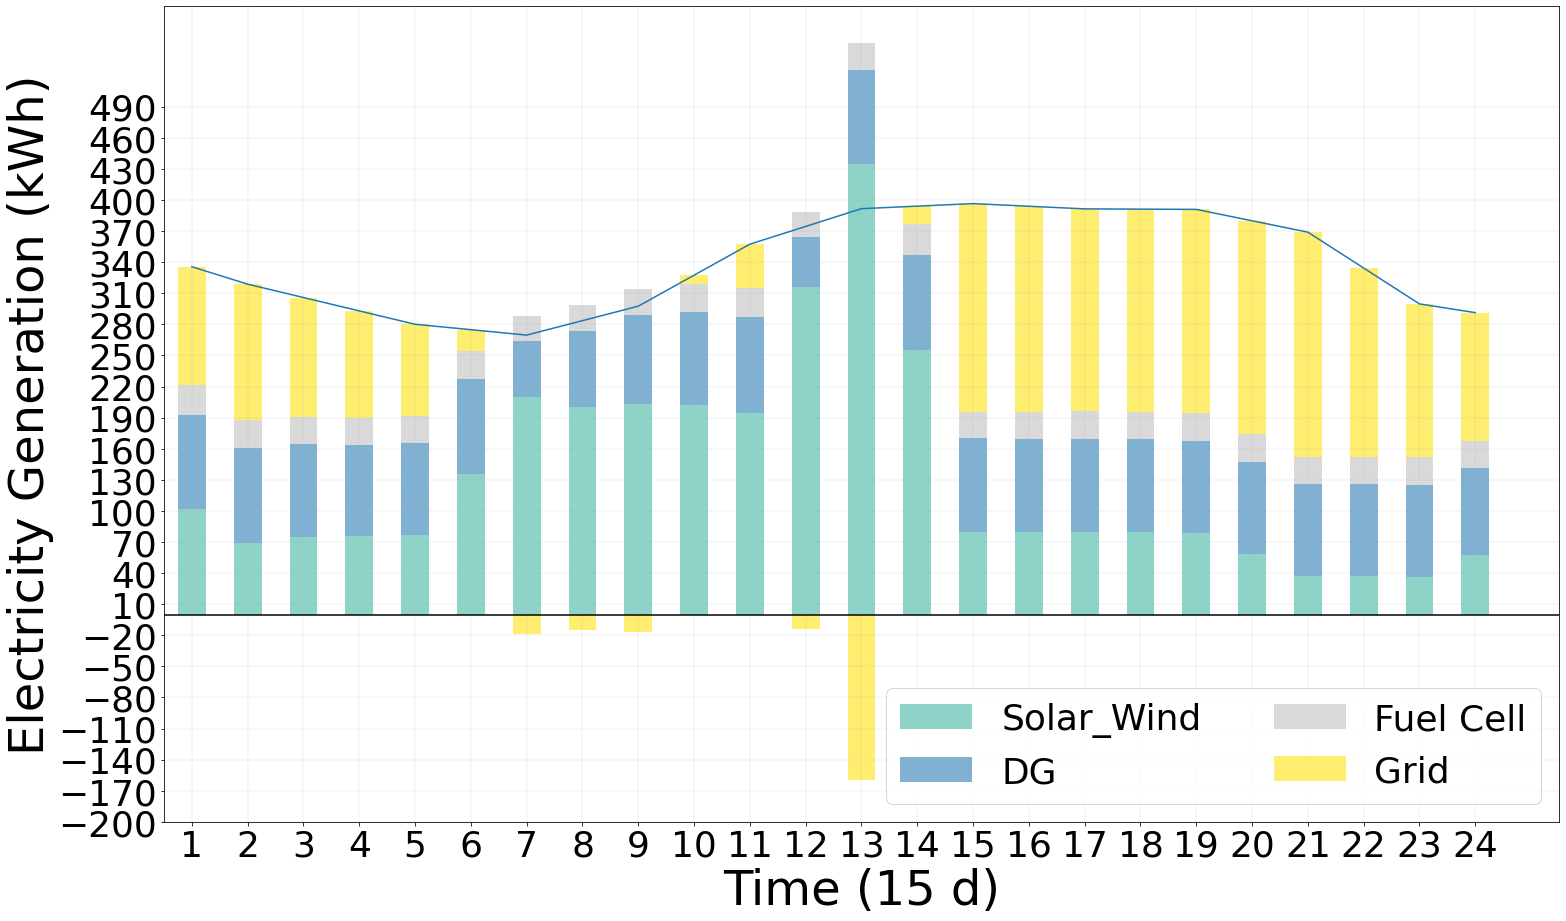

In [50]:
import numpy as np
T = 24
Time = range(T)
# i = 0
# P_el = dv_dict['P_cr2T'] + dv_dict['P_dg2T'] + dv_dict['P_grid2T']
# P_el[1:25]
# # P_total = dv_dict['P_cr1T'] +dv_dict['P_cr2T']  + dv_dict['P_dgT']+  dv_dict['P_gridT'] + dv_dict['P_fcT']
# P_total
# P_solarmax = dv_dict['P_sol_maxT']
# P_windmax = dv_dict['P_wind_maxT']

import pandas as pd
df_dict = dict()
df_dict['Solar_Wind'] = dv_dict['P_cr1T']

df_dict['DG'] = dv_dict['P_dg1T']

df_dict['Fuel Cell'] = dv_dict['P_fcT']

df_dict['Grid'] = dv_dict['P_grid1T']

# df_dict['Solar'] = dv_dict['P_sol_maxT']

df_dict['Time'] = [i for i in range(1,25)]
df_main = pd.DataFrame(df_dict)
df_main.set_index(['Time'], inplace=True)


# set the values for the x-axis that we want to plot,
# in this case the time values in years
Time2 = [i for i in Time]

# iterate through the list of countries, and create a plot
# .plot.bar makes bar charts
ax = df_main.plot.bar(stacked=True, figsize=(25,15), cmap = 'Set3')
# make room for the legend, and sets in the upper right corner
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]+1)

leg1 = ax.legend(loc='lower right', ncol=2, fontsize = 36)
# add the country name to the top of the chart.
ax.axhline(y=0, color='k')
# ax.axvline(x=0, color='k')
# ax.set_title('Badarpur, Ecological cost is minimized', fontsize = 48)
ax.tick_params(axis="x", labelrotation=0)
ax.set_xlabel('Time (15 d)', fontsize = 48)
ax.set_ylabel('Electricity Generation (kWh)', fontsize = 48)
plt.plot(Time2,dv_dict['P_lT'])



plt.yticks(np.arange(-200, 500, 30), fontsize = 36)
plt.xticks(fontsize = 36)
plt.grid(linestyle='--', linewidth=0.25)
# leg2 = ax.legend([P_totalload,P_hhload,P_electro,P_solarp,P_windp ],['Total Load', 'Household Load', 'Electrolyzer Load', 'Maximum Solar Energy','Maximum Wind Energy'], loc='lower left', ncol=2, fontsize = 25, facecolor="gray")
# ax.add_artist(leg1)
# zero_line = np.zeros(24)

# plt.plot(Time2,zero_line,'-b')

plt.show()

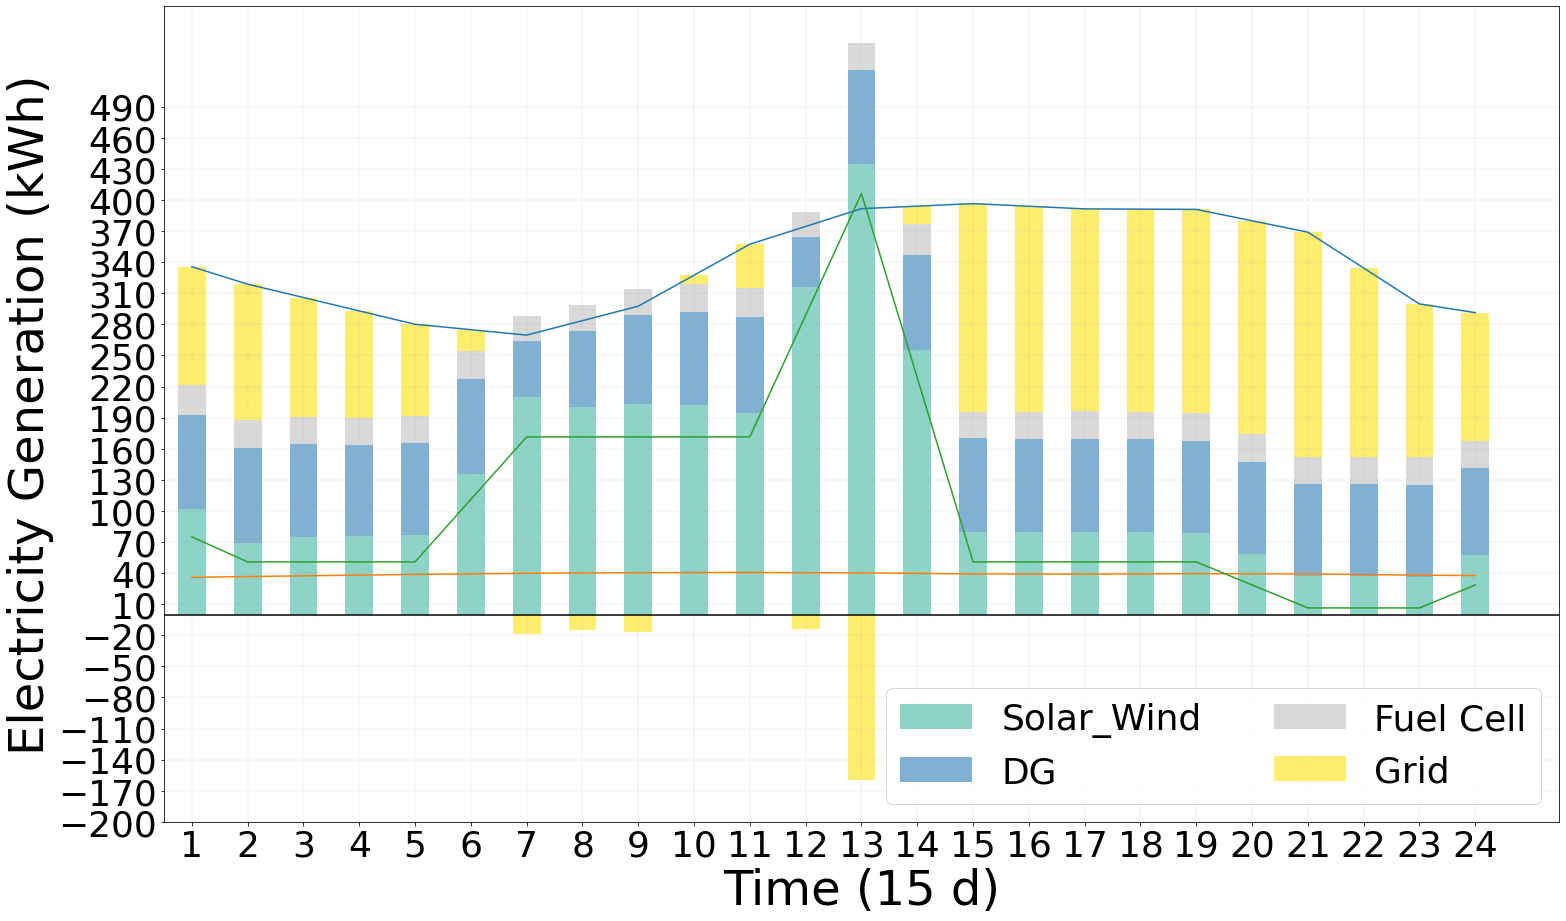

In [51]:
import numpy as np
T = 24
Time = range(T)
# i = 0
# P_el = dv_dict['P_cr2T'] + dv_dict['P_dg2T'] + dv_dict['P_grid2T']
# P_el[1:25]
# # P_total = dv_dict['P_cr1T'] +dv_dict['P_cr2T']  + dv_dict['P_dgT']+  dv_dict['P_gridT'] + dv_dict['P_fcT']
# P_total
# P_solarmax = dv_dict['P_sol_maxT']
# P_windmax = dv_dict['P_wind_maxT']

import pandas as pd
df_dict = dict()
df_dict['Solar_Wind'] = dv_dict['P_cr1T']

df_dict['DG'] = dv_dict['P_dg1T']

df_dict['Fuel Cell'] = dv_dict['P_fcT']

df_dict['Grid'] = dv_dict['P_grid1T']

# df_dict['Solar'] = dv_dict['P_sol_maxT']

df_dict['Time'] = [i for i in range(1,25)]
df_main = pd.DataFrame(df_dict)
df_main.set_index(['Time'], inplace=True)


# set the values for the x-axis that we want to plot,
# in this case the time values in years
Time2 = [i for i in Time]

# iterate through the list of countries, and create a plot
# .plot.bar makes bar charts
ax = df_main.plot.bar(stacked=True, figsize=(25,15), cmap = 'Set3')
# make room for the legend, and sets in the upper right corner
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]+1)

# leg1 = ax.legend(loc='lower right', ncol=2, fontsize = 36)
# add the country name to the top of the chart.
ax.axhline(y=0, color='k')
# ax.axvline(x=0, color='k')
# ax.set_title('Badarpur, Ecological cost is minimized', fontsize = 48)
ax.tick_params(axis="x", labelrotation=0)
ax.set_xlabel('Time (15 d)', fontsize = 48)
ax.set_ylabel('Electricity Generation (kWh)', fontsize = 48)
# plt.plot(Time2,dv_dict['P_lT'])
# plt.plot(Time2,dv_dict['P_sol_maxT'])
# plt.plot(Time2,dv_dict['P_wind_maxT'])
ax.plot(Time2,dv_dict['P_lT'])
ax.plot(Time2,dv_dict['P_sol_maxT'])
ax.plot(Time2,dv_dict['P_wind_maxT'])
#ax.legend(['P_lT', "P_sol_maxT", "P_wind_maxT"], fontsize = 36)
ax.legend(loc='lower right', ncol=2, fontsize = 36)


plt.yticks(np.arange(-200, 500, 30), fontsize = 36)
plt.xticks(fontsize = 36)
plt.grid(linestyle='--', linewidth=0.25)
# leg2 = ax.legend([P_totalload,P_hhload,P_electro,P_solarp,P_windp ],['Total Load', 'Household Load', 'Electrolyzer Load', 'Maximum Solar Energy','Maximum Wind Energy'], loc='lower left', ncol=2, fontsize = 25, facecolor="gray")
# ax.add_artist(leg1)
# zero_line = np.zeros(24)

# plt.plot(Time2,zero_line,'-b')

plt.savefig("C2\\"+"fig_1"+".jpeg")
plt.show()

In [52]:
dv_dict.keys()

dict_keys(['P_gridT', 'P_grid1T', 'P_grid2T', 'P_cr1T', 'P_cr2T', 'P_fcT', 'P_dg1T', 'P_dg2T', 'P_dgT', 'n_h2T', 'n_fcT', 'n_fc2T', 'n_fc_maxT', 'P_lT', 'P_sol_maxT', 'P_wind_maxT', 'P_fcinT', 'C_gridT', 'ATRT', 'X_SCRT', 'FSCRT', 'ZSCRT', 'SCOT', 'DCOT', 'f1', 'f2', 'f3'])

In [53]:
print("f1 min time index: {}, value: {}".format(dv_dict['f1'].index(min(dv_dict['f1'])) + 1, min(dv_dict['f1'])))
i = dv_dict['f1'].index(min(dv_dict['f1']))
print("f1: {}, f2: {}, f3: {}".format(dv_dict['f1'][i], dv_dict['f2'][i], dv_dict['f3'][i]))
print("P_grid1T: {}, P_dg1T: {}, P_sol_maxT: {}, P_wind_maxT: {}, P_fcT: {}".format(dv_dict['P_grid1T'][i], 
                                                                                    dv_dict['P_dg1T'][i], 
                                                                                    dv_dict['P_sol_maxT'][i], 
                                                                                    dv_dict['P_wind_maxT'][i], 
                                                                                    dv_dict['P_fcT'][i]))
print("f2 min time index: {}, value: {}".format(dv_dict['f2'].index(min(dv_dict['f2'])) + 1, min(dv_dict['f2'])))
i = dv_dict['f2'].index(min(dv_dict['f2']))
print("f1: {}, f2: {}, f3: {}".format(dv_dict['f1'][i], dv_dict['f2'][i], dv_dict['f3'][i]))
print("P_grid1T: {}, P_dg1T: {}, P_sol_maxT: {}, P_wind_maxT: {}, P_fcT: {}".format(dv_dict['P_grid1T'][i], 
                                                                                    dv_dict['P_dg1T'][i], 
                                                                                    dv_dict['P_sol_maxT'][i], 
                                                                                    dv_dict['P_wind_maxT'][i], 
                                                                                    dv_dict['P_fcT'][i]))
print("f3 min time index: {}, value: {}".format(dv_dict['f3'].index(min(dv_dict['f3'])) + 1, min(dv_dict['f3'])))
i = dv_dict['f3'].index(min(dv_dict['f3']))
print("f1: {}, f2: {}, f3: {}".format(dv_dict['f1'][i], dv_dict['f2'][i], dv_dict['f3'][i]))
print("P_grid1T: {}, P_dg1T: {}, P_sol_maxT: {}, P_wind_maxT: {}, P_fcT: {}".format(dv_dict['P_grid1T'][i], 
                                                                                    dv_dict['P_dg1T'][i], 
                                                                                    dv_dict['P_sol_maxT'][i], 
                                                                                    dv_dict['P_wind_maxT'][i], 
                                                                                    dv_dict['P_fcT'][i]))

print("f1 max time index: {}, value: {}".format(dv_dict['f1'].index(max(dv_dict['f1'])) + 1, max(dv_dict['f1'])))
i = dv_dict['f1'].index((max(dv_dict['f1'])))
print("f1: {}, f2: {}, f3: {}".format(dv_dict['f1'][i], dv_dict['f2'][i], dv_dict['f3'][i]))
print("P_grid1T: {}, P_dg1T: {}, P_sol_maxT: {}, P_wind_maxT: {}, P_fcT: {}".format(dv_dict['P_grid1T'][i], 
                                                                                    dv_dict['P_dg1T'][i], 
                                                                                    dv_dict['P_sol_maxT'][i], 
                                                                                    dv_dict['P_wind_maxT'][i], 
                                                                                    dv_dict['P_fcT'][i]))
print("f2 max time index: {}, value: {}".format(dv_dict['f2'].index(max(dv_dict['f2'])) + 1, max(dv_dict['f2'])))
i = dv_dict['f2'].index((max(dv_dict['f2'])))
print("f1: {}, f2: {}, f3: {}".format(dv_dict['f1'][i], dv_dict['f2'][i], dv_dict['f3'][i]))
print("P_grid1T: {}, P_dg1T: {}, P_sol_maxT: {}, P_wind_maxT: {}, P_fcT: {}".format(dv_dict['P_grid1T'][i], 
                                                            dv_dict['P_dg1T'][i], 
                                                            dv_dict['P_sol_maxT'][i], 
                                                            dv_dict['P_wind_maxT'][i], 
                                                            dv_dict['P_fcT'][i]))
print("f3 max time index: {}, value: {}".format(dv_dict['f3'].index(max(dv_dict['f3'])) + 1, max(dv_dict['f3'])))
i = dv_dict['f3'].index((max(dv_dict['f3'])))
print("f1: {}, f2: {}, f3: {}".format(dv_dict['f1'][i], dv_dict['f2'][i], dv_dict['f3'][i]))
print("P_grid1T: {}, P_dg1T: {}, P_sol_maxT: {}, P_wind_maxT: {}, P_fcT: {}".format(dv_dict['P_grid1T'][i], 
                                                            dv_dict['P_dg1T'][i], 
                                                            dv_dict['P_sol_maxT'][i], 
                                                            dv_dict['P_wind_maxT'][i], 
                                                            dv_dict['P_fcT'][i]))

print("f1 average value: {}".format(np.mean(dv_dict['f1'])))
print("f2 average value: {}".format(np.mean(dv_dict['f2'])))
print("f3 average value: {}".format(np.mean(dv_dict['f3'])))
print("ATRT average value: {}".format(np.mean(dv_dict['ATRT'])))

f1 min time index: 13, value: -116.55181910260748
f1: -116.55181910260748, f2: -77.1262308229752, f3: 0.048159623478709744
P_grid1T: -159.62301054, P_dg1T: 90.230917705, P_sol_maxT: 40.16412647518714, P_wind_maxT: 406.2345594841499, P_fcT: 26.045233878
f2 min time index: 13, value: -77.1262308229752
f1: -116.55181910260748, f2: -77.1262308229752, f3: 0.048159623478709744
P_grid1T: -159.62301054, P_dg1T: 90.230917705, P_sol_maxT: 40.16412647518714, P_wind_maxT: 406.2345594841499, P_fcT: 26.045233878
f3 min time index: 13, value: 0.048159623478709744
f1: -116.55181910260748, f2: -77.1262308229752, f3: 0.048159623478709744
P_grid1T: -159.62301054, P_dg1T: 90.230917705, P_sol_maxT: 40.16412647518714, P_wind_maxT: 406.2345594841499, P_fcT: 26.045233878
f1 max time index: 21, value: 2864.112299161307
f1: 2864.112299161307, f2: 118.18556629286401, f3: 1.0191612340966654
P_grid1T: 216.84071912, P_dg1T: 88.682930075, P_sol_maxT: 39.140592481053105, P_wind_maxT: 6.34741499193984, P_fcT: 25.96045

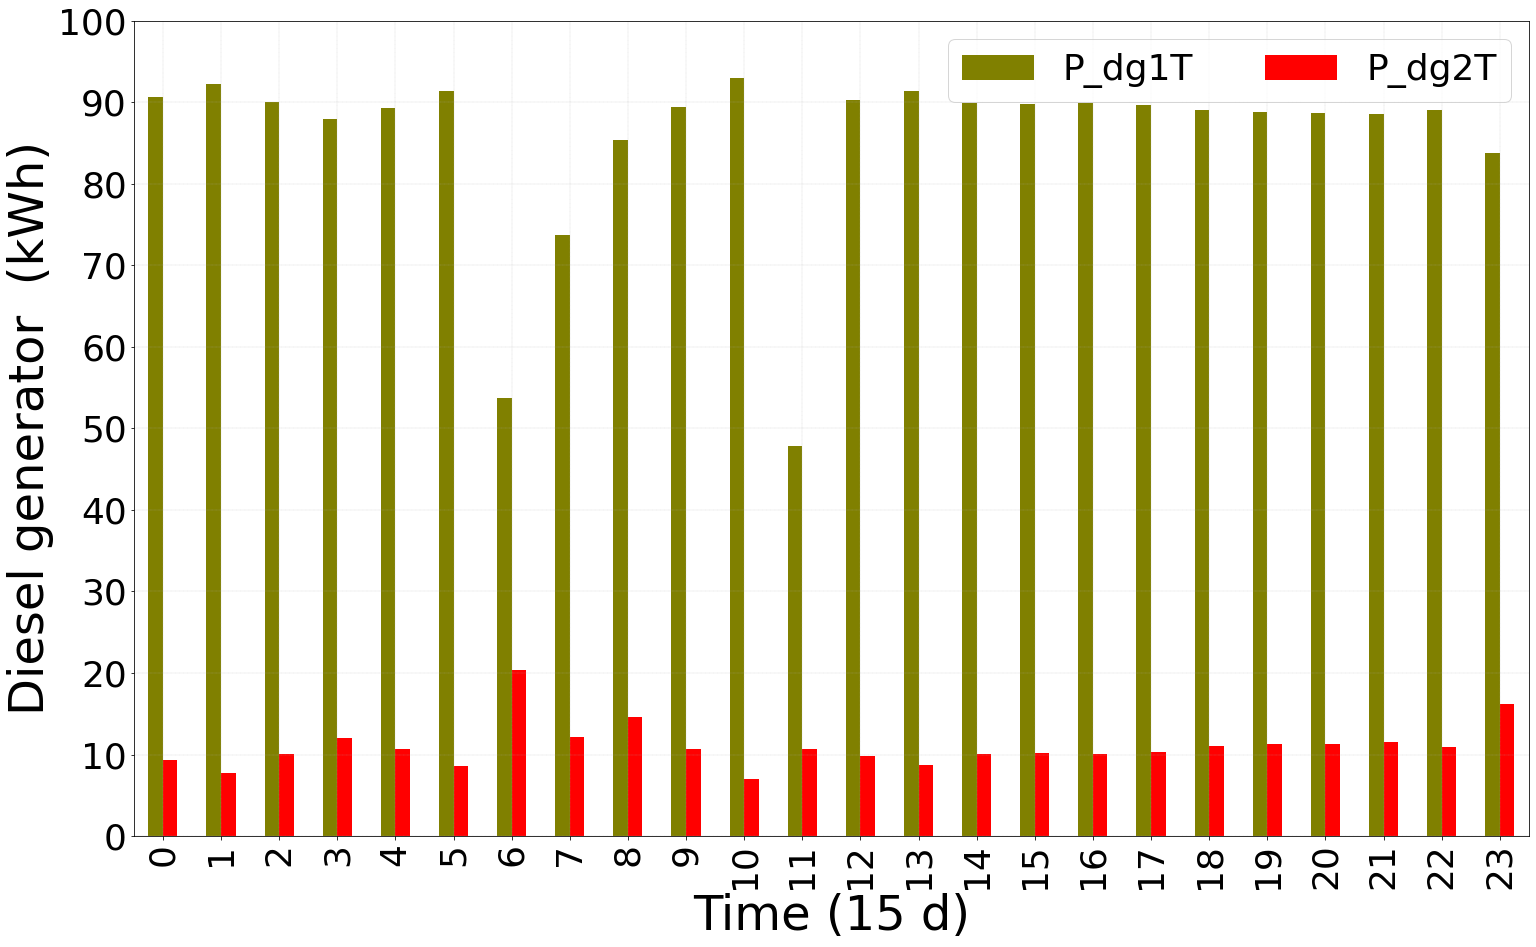

In [54]:
ax = pd.DataFrame({"P_dg1T": dv_dict['P_dg1T'], "P_dg2T": dv_dict['P_dg2T']}).plot.bar(stacked=False, figsize=(25,15), color = ["olive", "red"])
ax.legend(loc='upper right', ncol=2, fontsize = 36)


plt.yticks(np.arange(0, 110, 10), fontsize = 36)
plt.xticks(fontsize = 36)
plt.grid(linestyle='--', linewidth=0.25)
ax.set_xlabel('Time (15 d)', fontsize = 48)
ax.set_ylabel('Diesel generator  (kWh)', fontsize = 48)
plt.savefig("C2\\"+"fig_2"+".jpeg")

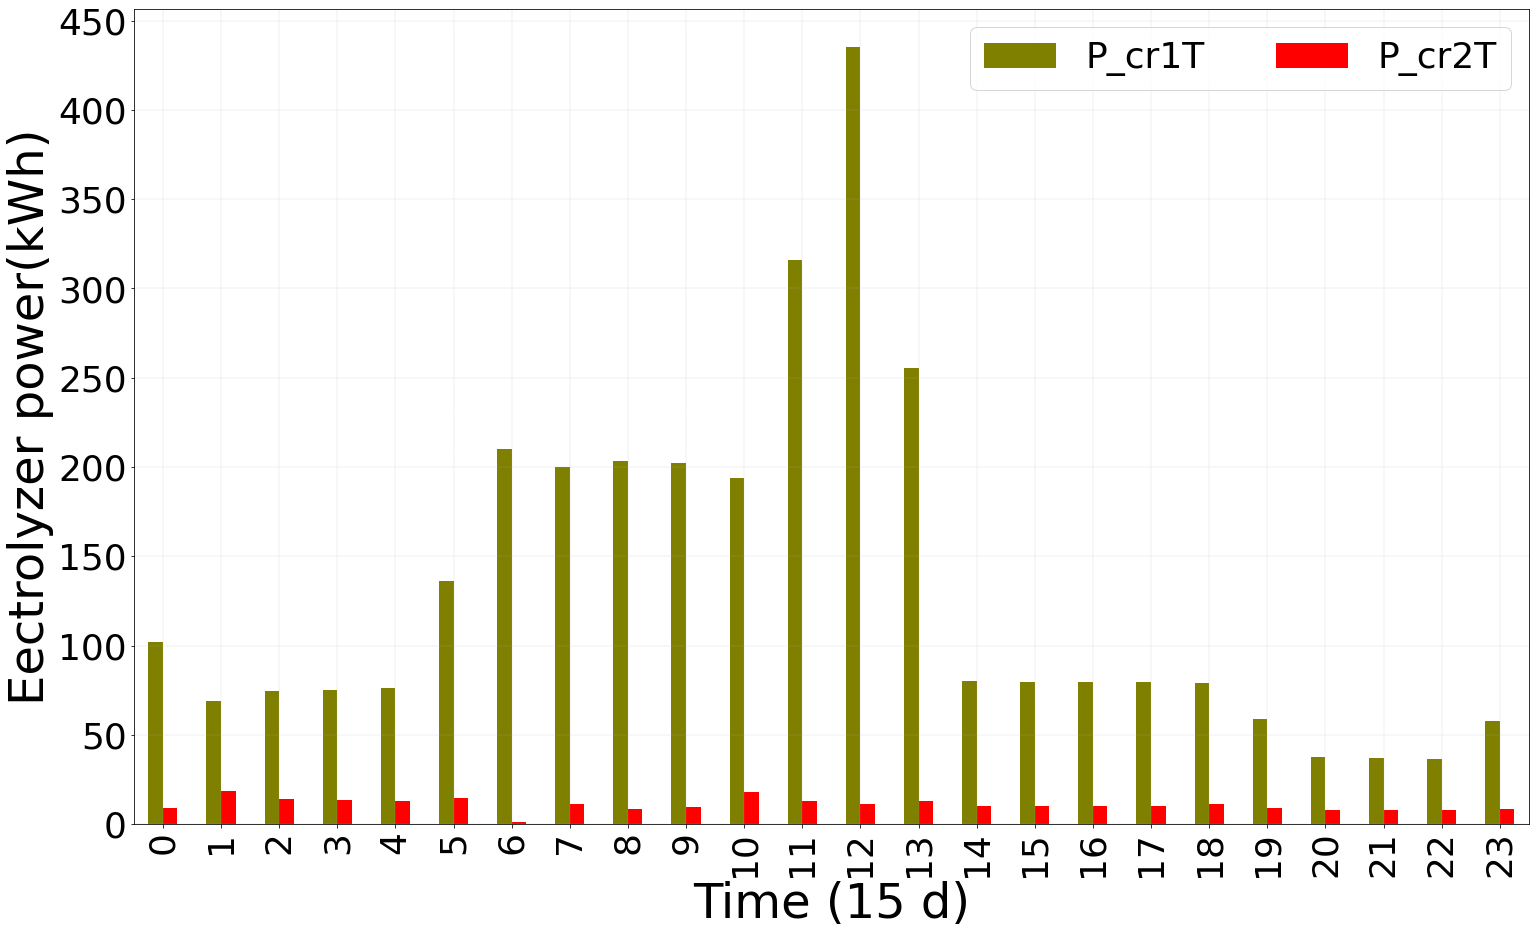

In [55]:
ax = pd.DataFrame({"P_cr1T": dv_dict['P_cr1T'], "P_cr2T": dv_dict['P_cr2T']}).plot.bar(stacked=False, figsize=(25,15), color = ["olive", "red"])
ax.legend(loc='upper right', ncol=2, fontsize = 36)


plt.yticks(np.arange(0, 500, 50), fontsize = 36)
plt.xticks(fontsize = 36)
plt.grid(linestyle='--', linewidth=0.25)
ax.set_xlabel('Time (15 d)', fontsize = 48)
ax.set_ylabel('Eectrolyzer power(kWh)', fontsize = 48)
plt.savefig("C2\\"+"fig_3"+".jpeg")

In [56]:
SCO = np.array(dv_dict['SCOT'])
DCO = np.array(dv_dict['DCOT'])
ESI = (SCO - DCO)/(DCO)
ESI

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00444444,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

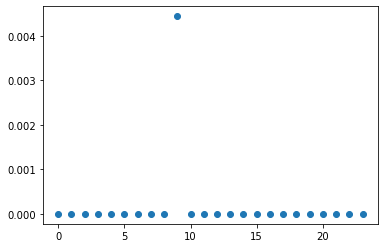

In [57]:
plt.figure()
# plt.subplot(1, 2, 1)
# plt.scatter(range(len(SCO)), SCO, marker='o')
# plt.subplot(1, 2, 1)
# plt.scatter(range(len(DCO)), DCO, marker='.')
plt.scatter(range(len(ESI)), ESI)
# # # plt.xlabel('Time (15 d)', fontsize = 15)
# # plt.ylabel('ESI', fontsize = 15)
# plt.legend(['SCO', "DCO", "ESI"])
# ax.legend(loc='upper left', ncol=2, fontsize = 36)
plt.savefig("C2\\"+"fig_4"+".jpeg")
plt.show()



In [58]:
DCO

array([0.079, 0.076, 0.068, 0.102, 0.152, 0.168, 0.191, 0.154, 0.193,
       0.225, 0.193, 0.161, 0.166, 0.169, 0.13 , 0.141, 0.13 , 0.13 ,
       0.194, 0.234, 0.224, 0.125, 0.115, 0.111])

In [59]:
SCO

array([0.079, 0.076, 0.068, 0.102, 0.152, 0.168, 0.191, 0.154, 0.193,
       0.226, 0.193, 0.161, 0.166, 0.169, 0.13 , 0.141, 0.13 , 0.13 ,
       0.194, 0.234, 0.224, 0.125, 0.115, 0.111])

In [60]:
(SCO-DCO)/DCO

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00444444,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

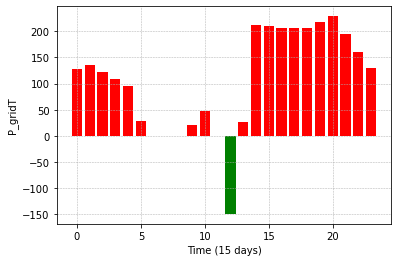

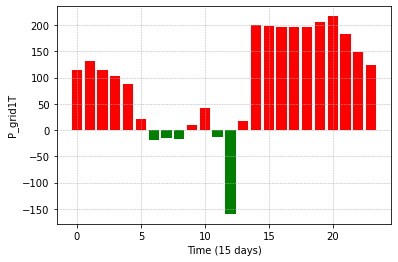

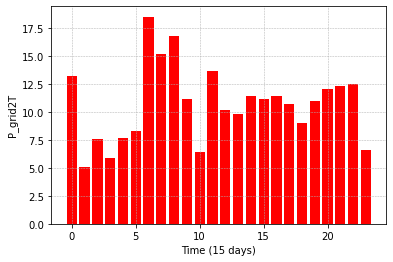

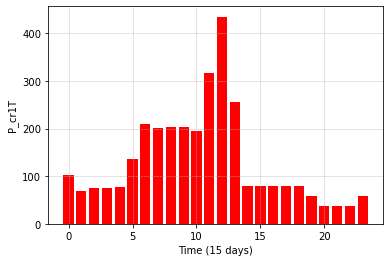

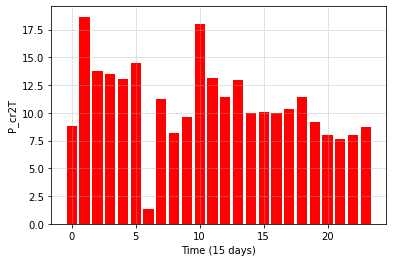

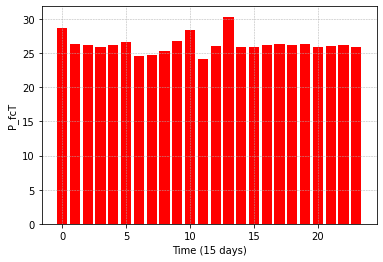

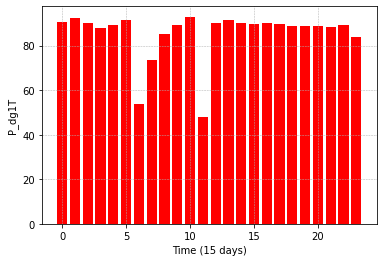

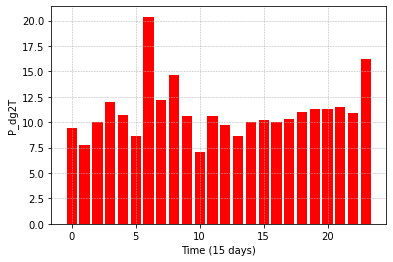

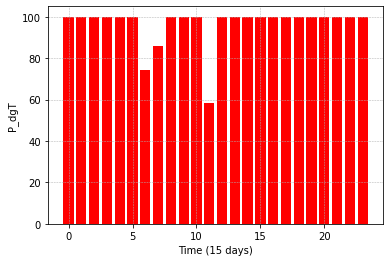

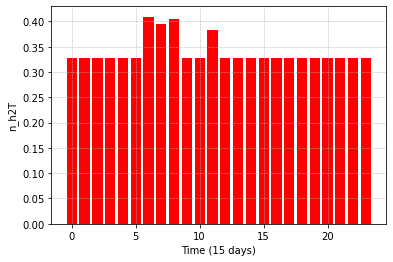

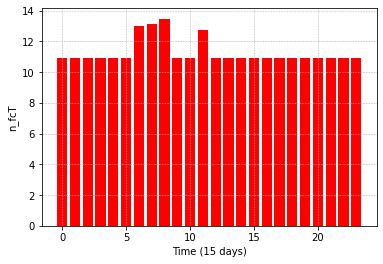

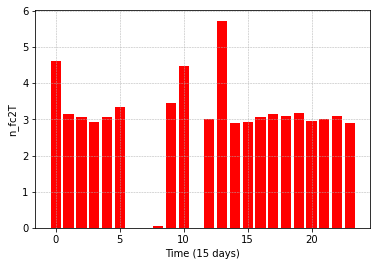

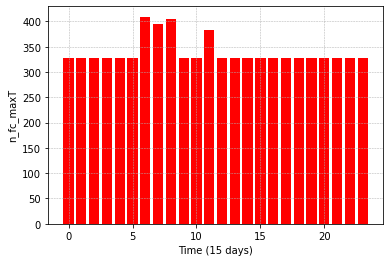

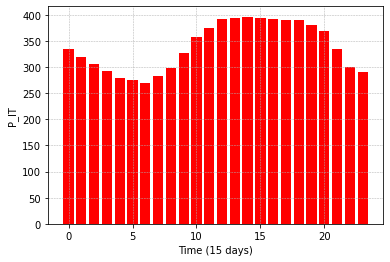

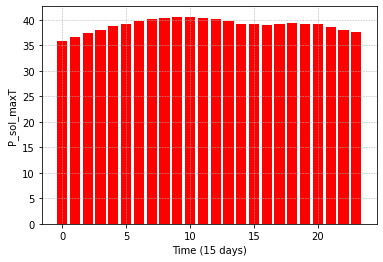

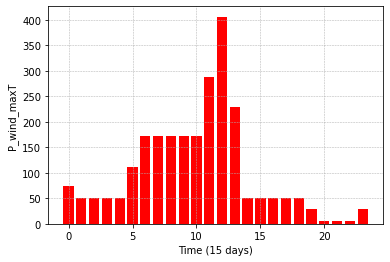

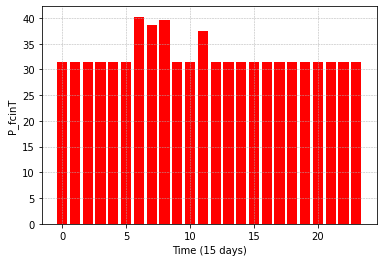

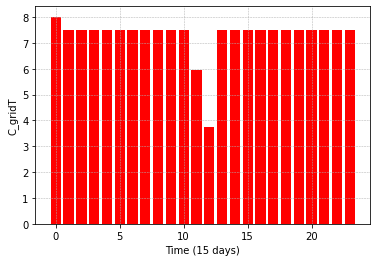

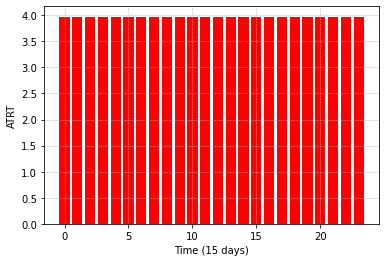

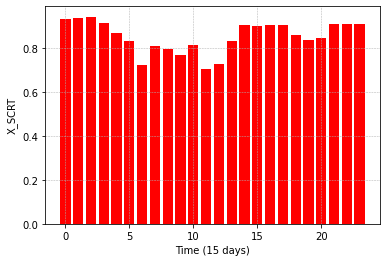

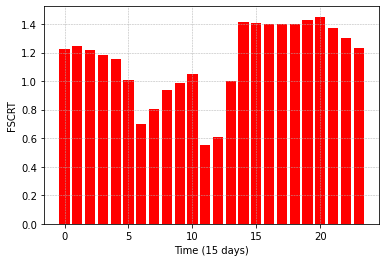

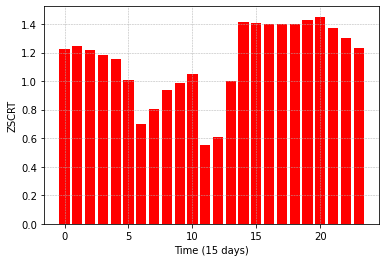

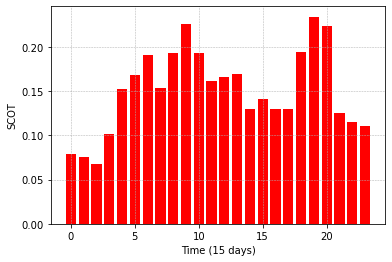

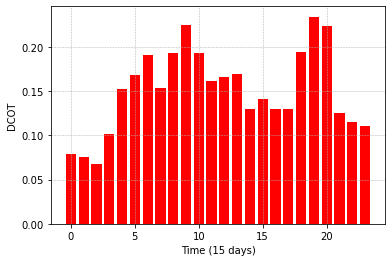

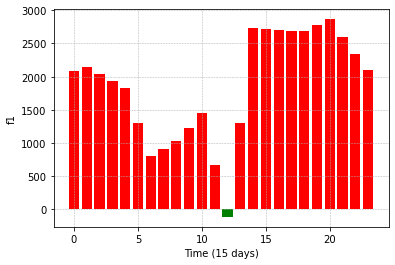

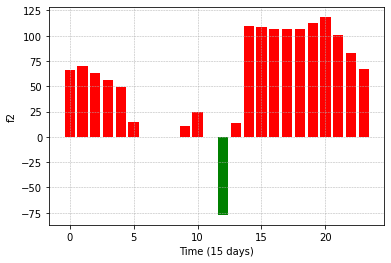

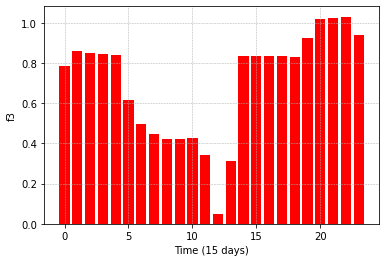

In [61]:
colors = ["red", "green"]
for dvi in keys_list:
    plt.figure()
    for i, j in zip(list(range(len(dv_dict[dvi]))), dv_dict[dvi]):
        if j < 0:
            plt.bar([i], height = [j], color = ["green"])
        else:
            plt.bar([i], height = [j], color = ["red"])
#     plt.title(dvi)
    plt.xlabel("Time (15 days)")
    plt.ylabel(dvi)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.savefig("C2\\"+dvi+".jpeg")
    plt.show()
    
    
#     plt.bar(x, height = h, color = c)

import matplotlib.pyplot as plt
import numpy as np

for h in range(0,T):
    plt.figure()
    plt.scatter(f1[h], f2[h])
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.title('t= '+ str((1+h)*15)+ ' days = '+ str((1+h)/2) + ' month(s)')
    plt.show
    
    plt.figure()
    plt.scatter(f1[h], f3[h])
    plt.xlabel('f1')
    plt.ylabel('f3')
    plt.title('t= '+ str((1+h)*15)+ ' days = '+ str((1+h)/2) + ' month(s)')
    plt.show
    
    plt.figure()
    plt.scatter(f2[h], f3[h])
    plt.xlabel('f2')
    plt.ylabel('f3')
    plt.title('t= '+ str((1+h)*15)+ ' days = '+ str((1+h)/2) + ' month(s)')
    plt.show
    

np.round(f1)


np.round(f2)


np.round(f3)

import pandas as pd

dff1= pd.DataFrame(f1)
dff1.to_csv('f1.csv')

In [62]:
P_wind_maxT.T

array([[ 74.90605903,  50.77931994,  50.77931994,  50.77931994,
         50.77931994, 111.07976236, 171.38020478, 171.38020478,
        171.38020478, 171.38020478, 171.38020478, 288.80738213,
        406.23455948, 228.50693971,  50.77931994,  50.77931994,
         50.77931994,  50.77931994,  50.77931994,  28.56336746,
          6.34741499,   6.34741499,   6.34741499,  28.56336746],
       [ 74.90605903,  50.77931994,  50.77931994,  50.77931994,
         50.77931994, 111.07976236, 171.38020478, 171.38020478,
        171.38020478, 171.38020478, 171.38020478, 288.80738213,
        406.23455948, 228.50693971,  50.77931994,  50.77931994,
         50.77931994,  50.77931994,  50.77931994,  28.56336746,
          6.34741499,   6.34741499,   6.34741499,  28.56336746],
       [ 74.90605903,  50.77931994,  50.77931994,  50.77931994,
         50.77931994, 111.07976236, 171.38020478, 171.38020478,
        171.38020478, 171.38020478, 171.38020478, 288.80738213,
        406.23455948, 228.50693971,  5

FSCRT.T

In [63]:
import numpy as np
T = 24
Time = range(T)
# i = 0
# P_el = dv_dict['P_cr2T'] + dv_dict['P_dg2T'] + dv_dict['P_grid2T']
# P_el[1:25]
# # P_total = dv_dict['P_cr1T'] +dv_dict['P_cr2T']  + dv_dict['P_dgT']+  dv_dict['P_gridT'] + dv_dict['P_fcT']
# P_total
# P_solarmax = dv_dict['P_sol_maxT']
# P_windmax = dv_dict['P_wind_maxT']

import pandas as pd
df_dict_dv = dict()
df_dict_dv['f1'] = f1

df_dict_dv['f2'] = f2

df_dict_dv['f3'] = f3

df_dict_dv['P_grid1T'] = P_grid1T

# df_dict['Solar'] = dv_dict['P_sol_maxT']

# df_dict['Time'] = [i for i in range(1,25)]
# df_main_dv = pd.DataFrame(df_dict_dv)
# df_main_dv.set_index(['P_grid1T'], inplace=True)


# # set the values for the x-axis that we want to plot,
# # in this case the time values in years
# Time2 = [i for i in Time]

# # iterate through the list of countries, and create a plot
# # .plot.bar makes bar charts
# ax = df_main.plot.bar(stacked=True, figsize=(25,15), cmap = 'Set3')
# # make room for the legend, and sets in the upper right corner
# ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]+1)

# leg1 = ax.legend(loc='lower right', ncol=2, fontsize = 36)
# # add the country name to the top of the chart.
# ax.axhline(y=0, color='k')
# # ax.axvline(x=0, color='k')
# # ax.set_title('Badarpur, Ecological cost is minimized', fontsize = 48)
# ax.tick_params(axis="x", labelrotation=0)
# ax.set_xlabel('Time (15 d)', fontsize = 48)
# ax.set_ylabel('Electricity Generation (kWh)', fontsize = 48)
# plt.plot(Time2,dv_dict['P_lT'])



# plt.yticks(np.arange(-200, 500, 30), fontsize = 36)
# plt.xticks(fontsize = 36)
# plt.grid(linestyle='--', linewidth=0.25)
# # leg2 = ax.legend([P_totalload,P_hhload,P_electro,P_solarp,P_windp ],['Total Load', 'Household Load', 'Electrolyzer Load', 'Maximum Solar Energy','Maximum Wind Energy'], loc='lower left', ncol=2, fontsize = 25, facecolor="gray")
# # ax.add_artist(leg1)
# # zero_line = np.zeros(24)

# # plt.plot(Time2,zero_line,'-b')

# plt.show()
df_dict_dv

{'f1': array([[2110.46996179, 2110.46922592, 2110.46993206, 2109.28239515,
         2110.46987247, 2110.46993856, 1996.94512321, 2110.46981062,
         2110.46983101, 2110.47006721, 2110.46994675, 2089.3536218 ,
         1996.94519646, 2098.15365852, 2093.73904359, 1996.94461367,
         2110.47003682, 2110.47004439, 2109.69188071, 2110.46994435,
         2119.35723398, 2107.12054252, 2110.46992871, 2110.47002372,
         2057.40538451, 2110.47063204, 2107.41764519, 2082.35936459,
         2099.39065541, 1996.94372142],
        [2048.79256883, 2048.79254752, 2048.79222307, 2048.79214483,
         2048.87409342, 2162.31878437, 2048.79228733, 2048.79242414,
         2117.80756756, 2048.79234328, 2048.79226948, 2162.32045591,
         2048.79232475, 2048.7924977 , 2147.38505029, 2048.79229382,
         2162.31864427, 2162.31867305, 2082.03739237, 2048.79235535,
         2162.31863067, 2088.62280479, 2125.40957121, 2048.7950449 ,
         2048.79214376, 2048.79264001, 2048.79231137, 204

In [64]:
print("f1 min time index: {}, value: {}".format(dv_dict['f1'].index(min(dv_dict['f1'])) + 1, min(dv_dict['f1'])))
print("f2 min time index: {}, value: {}".format(dv_dict['f2'].index(min(dv_dict['f2'])) + 1, min(dv_dict['f2'])))
print("f3 min time index: {}, value: {}".format(dv_dict['f3'].index(min(dv_dict['f3'])) + 1, min(dv_dict['f3'])))

print("f1 max time index: {}, value: {}".format(dv_dict['f1'].index(max(dv_dict['f1'])) + 1, max(dv_dict['f1'])))
print("f2 max time index: {}, value: {}".format(dv_dict['f2'].index(max(dv_dict['f2'])) + 1, max(dv_dict['f2'])))
print("f3 max time index: {}, value: {}".format(dv_dict['f3'].index(max(dv_dict['f3'])) + 1, max(dv_dict['f3'])))

print("f1 average value: {}".format(np.mean(dv_dict['f1'])))
print("f2 average value: {}".format(np.mean(dv_dict['f2'])))
print("f3 average value: {}".format(np.mean(dv_dict['f3'])))

f1 min time index: 13, value: -116.55181910260748
f2 min time index: 13, value: -77.1262308229752
f3 min time index: 13, value: 0.048159623478709744
f1 max time index: 21, value: 2864.112299161307
f2 max time index: 21, value: 118.18556629286401
f3 max time index: 23, value: 1.0298101984323602
f1 average value: 1866.625519836077
f2 average value: 54.66073158263171
f3 average value: 0.7003482890505633
